# Problem statement: Predict the customers that most likely to churn out of the platform

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

## 2. Read the dataset

In [33]:
purchase_history = pd.read_csv('dataset.csv')
purchase_history['timestamp'] = purchase_history['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') + timedelta(hours=5, minutes=30))

## 3. Define churn

> There are multiple ways of defining churn. In the present use case we consider the following:
> 1. Predictive modelling
> 2. Historical method 

### 3.1. Predictive modelling

In [26]:
# For predicting the churn, lets first define churn
# Since from the EDA and the cohorting logic we saw that for most use cases, a window of 1 month is fine,
# therefore we consider that if a user has not made a purchase in the last 1 month, then we consider it as churn

In [34]:
purchase_history["date"] = purchase_history["timestamp"].apply(lambda x: x.date())

In [49]:
cut_off_date = (purchase_history['date'].max() - timedelta(days=30))
print("Cutoff date: {}".format(cut_off_date))

Cutoff date: 2022-11-14


In [45]:
# Create a new column "churned" which is 1 if the customer has not made a purchase in the last 1 month (30 days)
purchase_history["churned"] = (purchase_history.groupby("user_id")["date"].transform("max") >= cut_off_date).astype(int)

#### 3.1.1. Prepare features

In [ ]:
# Seggregate some users for validation

In [171]:
data_df = purchase_history[purchase_history['timestamp'].apply(lambda x: (x.date()<=cut_off_date))]

In [172]:
# Average order value, Total order value, Total number of orders
feature_set1 = data_df.groupby('user_id').agg({'purchase_value': ['mean', 'sum', 'count']}).reset_index(col_level=1)
feature_set1.columns = ['user_id', 'aov', 'tov', 'count']
feature_set1.head(3)

,user_id,aov,tov,count
0,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,113.000000,113.0,1
1,000700164cee77c05439c206a588b66fe734150ede585f...,214.684211,4079.0,19
2,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,327.000000,327.0,1


In [173]:
# Age of the user
def diff_in_days(group):
    return (cut_off_date - group.min().date()).days

differences = data_df.groupby('user_id')['timestamp'].apply(diff_in_days)
feature_set2 = differences.to_frame().reset_index()
feature_set2.columns = ['user_id', 'age']

In [174]:
# Difference in days between first and the last purchase
def diff_in_days(group):
    return (group.max() - group.min()).days

differences = data_df.groupby('user_id')['timestamp'].apply(diff_in_days)
feature_set3 = differences.to_frame().reset_index()
feature_set3.columns = ['user_id', 'gap']

In [177]:
# Recency
def diff_in_days(group):
    return (cut_off_date - group.max().date()).days

differences = data_df.groupby('user_id')['timestamp'].apply(diff_in_days)
feature_set4 = differences.to_frame().reset_index()
feature_set4.columns = ['user_id', 'recency']

In [178]:
# Mean gap between orders
feature_set5 = data_df.groupby('user_id')["timestamp"].apply(lambda x: x.sort_values(ascending=True).diff().mean().days).to_frame().reset_index(col_level=1)
feature_set5.columns = ['user_id', 'average_gap']

feature_set5 = feature_set5.fillna(value={"average_gap":0})
feature_set5['average_gap'] = feature_set5['average_gap'].astype('int')

In [179]:
df = feature_set1.merge(feature_set2, on='user_id',how='left').merge(feature_set3, on='user_id',how='left').merge(feature_set4, on='user_id',how='left').merge(feature_set5, on='user_id',how='left')
df = df.merge(data_df[['user_id', 'churned']].drop_duplicates(), on='user_id',how='left')  
df.head(3)

,user_id,aov,tov,count,age,gap,recency,average_gap,churned
0,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,113.000000,113.0,1,61,0,61,0,0
1,000700164cee77c05439c206a588b66fe734150ede585f...,214.684211,4079.0,19,84,83,1,4,1
2,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,327.000000,327.0,1,66,0,66,0,1


In [180]:
df['churned'].value_counts(normalize=True)

1    0.541313
0    0.458687
Name: churned, dtype: float64

#### 3.1.2. Remove outliers

In [181]:
df_filtered = df[df['aov']<df['aov'].quantile(0.95)]
df_filtered = df_filtered[df_filtered['tov']<df_filtered['tov'].quantile(0.95)]
df_filtered.head(3)

,user_id,aov,tov,count,age,gap,recency,average_gap,churned
0,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,113.000000,113.0,1,61,0,61,0,0
1,000700164cee77c05439c206a588b66fe734150ede585f...,214.684211,4079.0,19,84,83,1,4,1
2,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,327.000000,327.0,1,66,0,66,0,1


#### 3.1.3. Feature scaling

In [182]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
scaler = StandardScaler()
df_filtered_scaled = df_filtered.copy(deep=True)
df_filtered_scaled[['aov', 'tov', 'count', 'age', 'gap', 'recency', 'average_gap']] = scaler.fit_transform(df_filtered_scaled[['aov', 'tov', 'count', 'age', 'gap', 'recency', 'average_gap']])
df_filtered_scaled.head(3)

,user_id,aov,tov,count,age,gap,recency,average_gap,churned
0,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,-1.324896,-0.751761,-0.725145,0.071682,-1.036844,1.411345,-0.731827,0
1,000700164cee77c05439c206a588b66fe734150ede585f...,-0.555836,1.211102,2.458196,0.923812,1.563061,-0.982436,-0.401234,1
2,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,0.293632,-0.645847,-0.725145,0.256928,-1.036844,1.610827,-0.731827,1


#### 3.1.4. Split data into train and test

In [183]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df_filtered_scaled, groups=df_filtered_scaled['user_id'])
train_inds, test_inds = next(split)

train_df = df_filtered.iloc[train_inds]
test_df = df_filtered.iloc[test_inds]

train_df_scaled = df_filtered_scaled.iloc[train_inds]
test_df_scaled = df_filtered_scaled.iloc[test_inds]

print("Total users({}) = Test({}) + Train ({})".format(df_filtered_scaled['user_id'].nunique(), train_df['user_id'].nunique(), test_df['user_id'].nunique()))

Total users(18796) = Test(15036) + Train (3760)


#### 3.1.5. Model training

In [184]:
X_train = train_df_scaled[['aov', 'tov', 'count', 'age', 'gap', 'average_gap']]
Y_train = train_df_scaled['churned']

X_test = test_df_scaled[['aov', 'tov', 'count', 'age', 'gap', 'average_gap']]
Y_test = test_df_scaled['churned']

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score

In [211]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, Y_train)

accuracy = rf_clf.score(X_test, Y_test)
print("Accuracy of RF model: {}".format(round(accuracy, 2)))

print("Classification report: ")
print(classification_report(Y_test, rf_clf.predict(X_test)))

print("ROC-AOC score: {}".format(roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1]) ))

Accuracy of RF model: 0.73
Classification report: 
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1786
           1       0.74      0.73      0.74      1974

    accuracy                           0.73      3760
   macro avg       0.73      0.73      0.73      3760
weighted avg       0.73      0.73      0.73      3760

ROC-AOC score: 0.8124690120502706


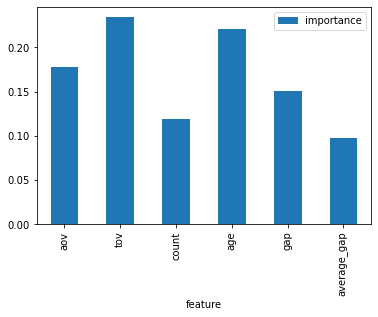

In [223]:
# Feature importance
pd.DataFrame((zip(list(rf_clf.feature_names_in_), rf_clf.feature_importances_)), columns=['feature', 'importance']).plot.bar(x='feature', y='importance');

In [212]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, Y_train)

accuracy = lr_clf.score(X_test, Y_test)
print("Accuracy of LR model: {}".format(round(accuracy, 2)))

print("Classification report: ")
print(classification_report(Y_test, lr_clf.predict(X_test)))

print("ROC-AOC score: {}".format(roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1]) ))

Accuracy of LR model: 0.74
Classification report: 
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1786
           1       0.78      0.72      0.75      1974

    accuracy                           0.74      3760
   macro avg       0.74      0.74      0.74      3760
weighted avg       0.75      0.74      0.74      3760

ROC-AOC score: 0.8124690120502706


array([0.12560574, 0.02919153, 0.70376546, 0.66645421, 1.28016495,
       0.08321301])

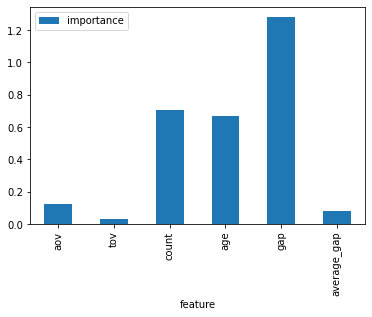

In [236]:
# Feature importance
pd.DataFrame((zip(list(lr_clf.feature_names_in_), abs(lr_clf.coef_[0]))), columns=['feature', 'importance']).plot.bar(x='feature', y='importance');

In [ ]:
# Clearly we can see that Logistic regression performs better than Random forest model
# Also we can reduce model complexity